In [1]:
import glob
import json
import os
import fitsio
import numpy as np

In [2]:
cut_files = glob.glob("mdet_data_v6cuts/*.fits")

In [3]:
cut_files[0]

'mdet_data_v6cuts/DES2038-4206_metadetect-v10_mdetcat_part0000.fits'

In [4]:
with open("config.json") as f:
    config = json.load(f)

In [5]:
config

{'mdet_data': '/gpfs02/astro/workarea/beckermr/des-y6-analysis/2023_02_25_run_mdet_nocoadd/mdet_data',
 'patches': '/astro/u/esheldon/y6patches/patches-altrem-npatch200-seed8888.fits.gz'}

In [6]:
all_files = glob.glob(f"{config['mdet_data']}/*_mdetcat_part0000.fits")

In [7]:
missing_files = sorted(set(os.path.basename(f) for f in all_files) - set(os.path.basename(f) for f in cut_files))

In [9]:
import tqdm
import sys
from des_y6utils.mdet import (
    make_mdet_cuts, add_extinction_correction_columns
)


ra = []
dec = []
for fname in tqdm.tqdm(missing_files, ncols=80, file=sys.stdout):
    # print('reading:', fname, flush=True)
    orig_data = fitsio.read(f"{config['mdet_data']}/{fname}")
    # print("    orig:", len(orig_data))
    
    # not all of these are in output
    inds, = np.where(
        (orig_data['psfrec_flags'] == 0) &
        (orig_data['gauss_flags'] == 0) &
        (orig_data['gauss_s2n'] > 5) &
        (orig_data['pgauss_T_flags'] == 0) &
        (orig_data['pgauss_s2n'] > 5) &
        (orig_data['pgauss_band_flux_flags_g'] == 0) &
        (orig_data['pgauss_band_flux_flags_r'] == 0) &
        (orig_data['pgauss_band_flux_flags_i'] == 0) &
        (orig_data['pgauss_band_flux_flags_z'] == 0) &
        (orig_data['mask_flags'] == 0) &
        (orig_data['shear_bands'] == '123')
    )
    orig_data = orig_data[inds]
    # print("    init cuts:", len(orig_data))

    subinds, = np.where(make_mdet_cuts(orig_data, "6"))
    # print("    mdet_cuts:", len(subinds))

    if len(subinds) == 0:
        ra.append(np.mean(orig_data["ra"]))
        dec.append(np.mean(orig_data["dec"]))
        continue
    else:
        print(f"    !bad tile {fname}")

    del orig_data
    break

100%|█████████████████████████████████████████| 241/241 [25:03<00:00,  6.24s/it]


/gpfs02/astro/workarea/beckermr/miniconda3/envs/des-hacking/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/gpfs02/astro/workarea/beckermr/miniconda3/envs/des-hacking/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/gpfs02/astro/workarea/beckermr/miniconda3/envs/des-hacking/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-

<a list of 1 Line2D objects>

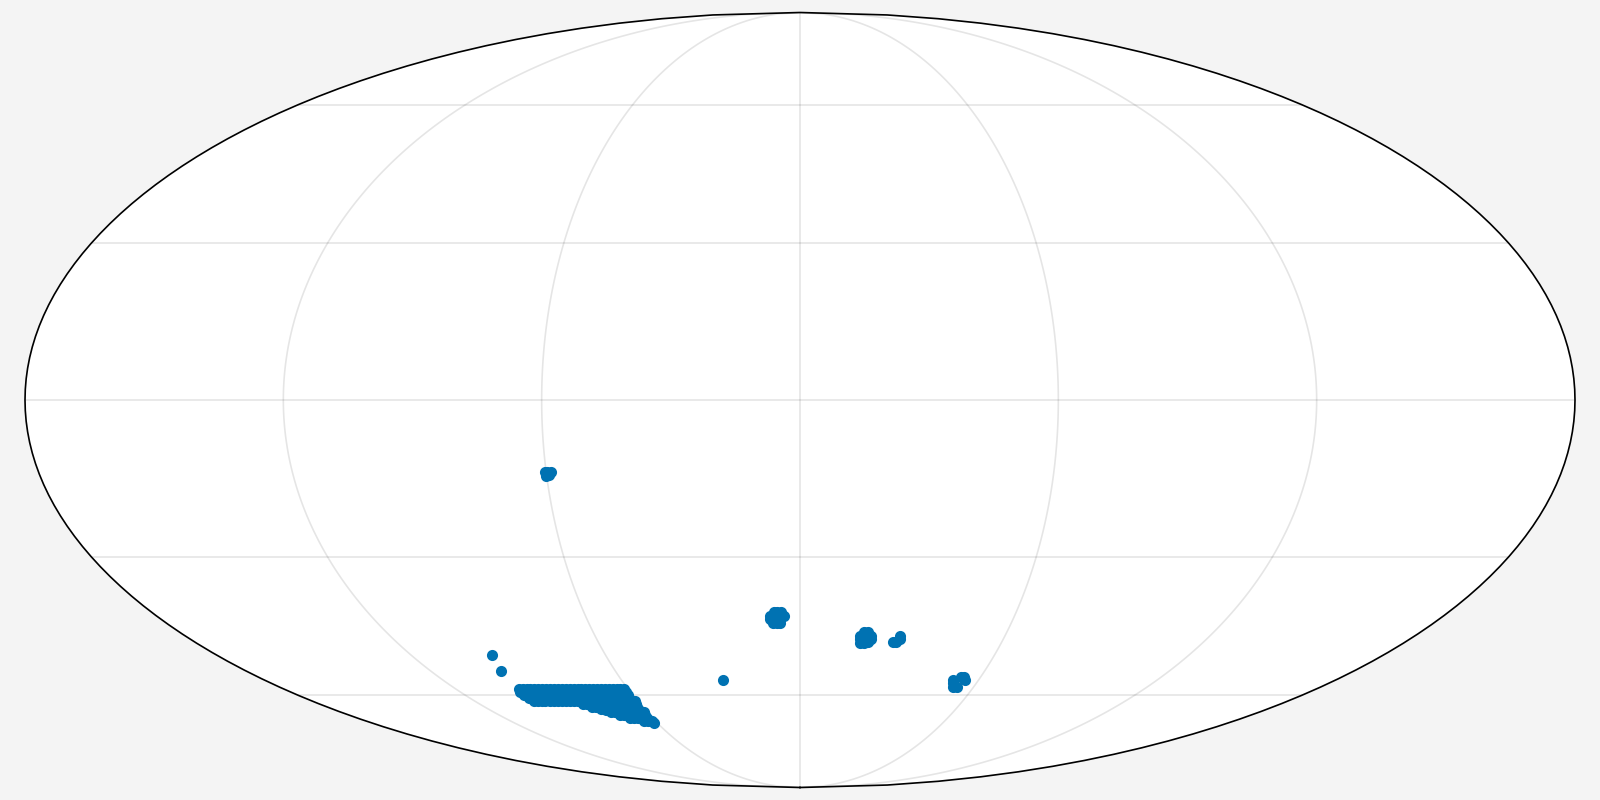

In [13]:
import proplot as pplt

fig, axs = pplt.subplots(proj="moll", figsize=(8, 4))
axs.invert_xaxis()

axs.plot(ra, dec, ".")

In [14]:
import healsparse as hsp

In [15]:
smap = hsp.HealSparseMap.read("$MEDS_DIR/y6-combined-hleda-gaiafull-des-stars-hsmap131k-mdet-v2.hsp")

In [16]:
smap.n_valid

22097207303

In [21]:
import skyproj
import matplotlib.pyplot as plt

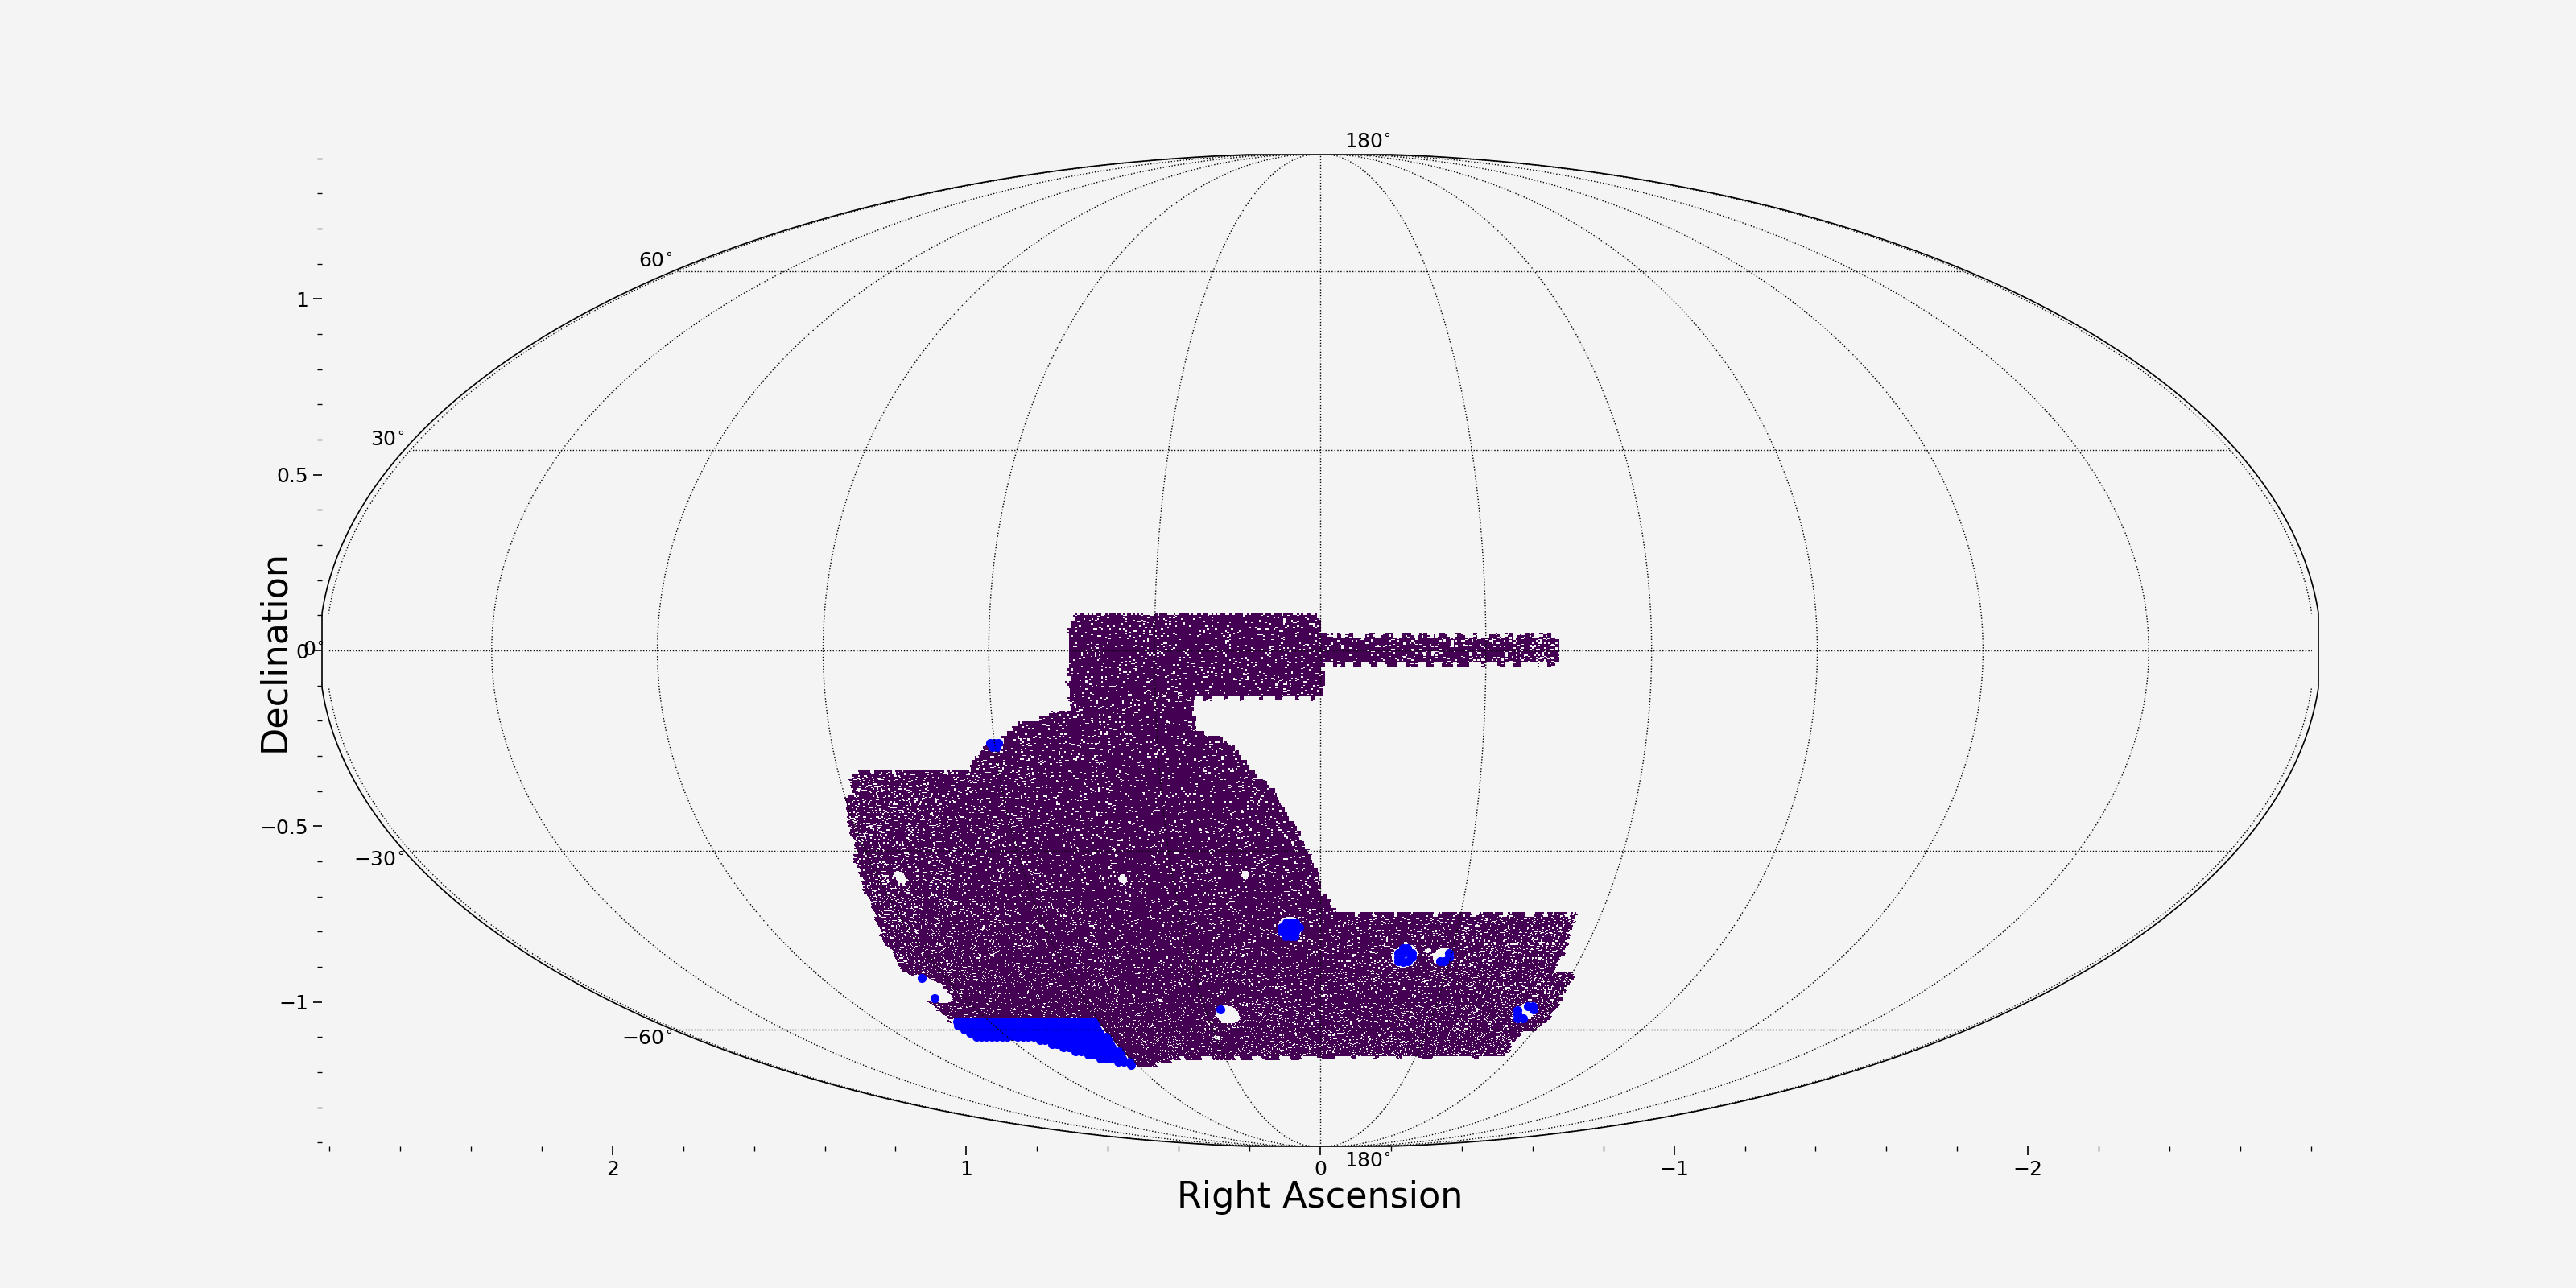

In [29]:
fig, axs = plt.subplots(figsize=(16, 8))

ax = axs

sp = skyproj.MollweideSkyproj(ax=ax)
sp.draw_hspmap(smap, zoom=False, norm=None, vmin=0, vmax=1, cmap="viridis")

sp.ax.plot(ra, dec, ".", color="b")